
**Dataset and Preprocessing**


In [ ]:
import numpy as np
import requests
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional, Dense, Embedding, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Custom Attention Layer for Text Generation
class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units
        self.W = Dense(units)
        self.V = Dense(1)

    def call(self, inputs):
        # inputs: [batch_size, time_steps, lstm_units]
        score = self.V(tf.nn.tanh(self.W(inputs)))  # [batch_size, time_steps, 1]
        attention_weights = tf.nn.softmax(score, axis=1)  # [batch_size, time_steps, 1]
        context_vector = attention_weights * inputs  # [batch_size, time_steps, lstm_units]
        context_vector = tf.reduce_sum(context_vector, axis=1)  # [batch_size, lstm_units]
        return context_vector, attention_weights


In [ ]:
# 1. Load Dataset
def load_gutenberg_text(url):
    response = requests.get(url)
    text = response.text
    return text

url = "http://www.gutenberg.org/files/1268/1268-0.txt"
raw_text = load_gutenberg_text(url)

# 2. Explore Dataset
print("Dataset Exploration:")
print(f"Total characters: {len(raw_text)}")
print(f"First 500 characters:\n{raw_text[:500]}")
unique_chars = sorted(set(raw_text))
print(f"Number of unique characters: {len(unique_chars)}")

Dataset Exploration:
Total characters: 1135474
First 500 characters:
*** START OF THE PROJECT GUTENBERG EBOOK 1268 ***

THE MYSTERIOUS ISLAND

by Jules Verne

1874




PART 1--DROPPED FROM THE CLOUDS



Chapter 1

“Are we rising again?” “No. On the contrary.” “Are we descending?”
 “Worse than that, captain! we are falling!” “For Heaven’s sake heave out
the ballast!” “There! the last sack is empty!” “Does the balloon rise?”
 “No!” “I hear a noise like the dashing of waves. The sea is below the
car! It cannot be more than 500 feet from us!” “Ov
Number of unique characters: 81


In [ ]:
# 3. Preprocess Dataset
def preprocess_text(text):
    # Remove Gutenberg header and footer
    start = text.find("*** START OF THIS PROJECT GUTENBERG EBOOK")
    end = text.find("*** END OF THIS PROJECT GUTENBERG EBOOK")
    if start != -1 and end != -1:
        text = text[start:end]

    # Clean text: lowercase, remove special characters, normalize whitespace
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned_text = preprocess_text(raw_text)
print(f"Length of cleaned text: {len(cleaned_text)}")

# Tokenize at character level
tokenizer = Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts([cleaned_text])
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Create sequences
max_sequence_length = 40
step = 1
sequences = []
next_chars = []

for i in range(0, len(cleaned_text) - max_sequence_length, step):
    seq = cleaned_text[i:i + max_sequence_length]
    next_char = cleaned_text[i + max_sequence_length]
    sequences.append(seq)
    next_chars.append(next_char)

# Convert to numerical sequences
X = tokenizer.texts_to_sequences(sequences)
y = tokenizer.texts_to_sequences(next_chars)

# Pad sequences and convert to numpy arrays
X = pad_sequences(X, maxlen=max_sequence_length, padding='pre')
y = np.array(y).reshape(-1)

# One-hot encode y
y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split into training and validation sets (80-20 split)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

Length of cleaned text: 1096484
Vocabulary size: 42
Shape of X: (1096444, 40)
Shape of y: (1096444, 42)
Training samples: 877155
Validation samples: 219289


**Models Training**

In [ ]:
# 4. Design and Train Models
embedding_dim = 50
hidden_units = 128
batch_size = 64
epochs = 20

# Function to calculate perplexity
def calculate_perplexity(model, X, y):
    probs = model.predict(X, verbose=0)
    log_probs = -np.log(probs + 1e-10)
    cross_entropy = np.mean(np.sum(log_probs * y, axis=1))
    perplexity = np.exp(cross_entropy)
    return perplexity

# Function to generate text
def generate_text(model, seed_text, length=100):
    generated = seed_text
    for _ in range(length):
        seq = tokenizer.texts_to_sequences([generated[-max_sequence_length:]])[0]
        seq = pad_sequences([seq], maxlen=max_sequence_length, padding='pre')
        pred = model.predict(seq, verbose=0)
        next_char_idx = np.argmax(pred[0])
        next_char = tokenizer.index_word.get(next_char_idx, '')
        generated += next_char
    return generated

# Store results
results = {}





In [ ]:
# 4.1 Standard RNN Model
model_rnn = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
    SimpleRNN(hidden_units, return_sequences=False),
    Dense(vocab_size, activation='softmax')
])
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_rnn = model_rnn.fit(X_train, y_train, validation_data=(X_val, y_val),
                           epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)
perplexity_rnn = calculate_perplexity(model_rnn, X_val, y_val)
sample_output_rnn = generate_text(model_rnn, cleaned_text[:max_sequence_length])
results['RNN'] = {'perplexity': perplexity_rnn, 'history': history_rnn.history, 'sample': sample_output_rnn}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.4280 - loss: 1.9637 - val_accuracy: 0.5426 - val_loss: 1.5291
Epoch 2/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.5543 - loss: 1.4886 - val_accuracy: 0.5681 - val_loss: 1.4388
Epoch 3/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - accuracy: 0.5749 - loss: 1.4124 - val_accuracy: 0.5802 - val_loss: 1.3987
Epoch 4/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.5832 - loss: 1.3804 - val_accuracy: 0.5830 - val_loss: 1.3870
Epoch 5/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.5877 - loss: 1.3621 - val_accuracy: 0.5854 - val_loss: 1.3777
Epoch 6/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - accuracy: 0.5921 - loss: 1.3495 - val_accuracy: 0.5875 - val_loss: 1.3687
Epoch 7/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 0.5937 - loss: 1.3399 - val_accuracy: 0.5901 - val_loss: 1.3601
Epoch 8/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step - accuracy: 

In [ ]:
# 4.2 LSTM Model
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
    LSTM(hidden_units, return_sequences=False),
    Dense(vocab_size, activation='softmax')
])
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val),
                             epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)
perplexity_lstm = calculate_perplexity(model_lstm, X_val, y_val)
sample_output_lstm = generate_text(model_lstm, cleaned_text[:max_sequence_length])
results['LSTM'] = {'perplexity': perplexity_lstm, 'history': history_lstm.history, 'sample': sample_output_lstm}

Epoch 1/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 96s 7ms/step - accuracy: 0.4146 - loss: 2.0051 - val_accuracy: 0.5467 - val_loss: 1.5159
Epoch 2/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 140s 7ms/step - accuracy: 0.5609 - loss: 1.4642 - val_accuracy: 0.5842 - val_loss: 1.3814
Epoch 3/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 150s 7ms/step - accuracy: 0.5911 - loss: 1.3548 - val_accuracy: 0.5995 - val_loss: 1.3275
Epoch 4/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 142s 7ms/step - accuracy: 0.6057 - loss: 1.2998 - val_accuracy: 0.6081 - val_loss: 1.2937
Epoch 5/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 143s 7ms/step - accuracy: 0.6143 - loss: 1.2668 - val_accuracy: 0.6101 - val_loss: 1.2790
Epoch 6/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 133s 7ms/step - accuracy: 0.6198 - loss: 1.2421 - val_accuracy: 0.6165 - val_loss: 1.2616
Epoch 7/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 150s 7ms/step - accuracy: 0.6249 - loss: 1.2273 - val_accuracy: 0.6202 - val_loss: 1.2513
Epoch 8/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 141s 7ms/step - acc

In [ ]:


# 4.3 Bidirectional LSTM Model
model_bilstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(hidden_units, return_sequences=False)),
    Dense(vocab_size, activation='softmax')
])
model_bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_bilstm = model_bilstm.fit(X_train, y_train, validation_data=(X_val, y_val),
                                 epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)
perplexity_bilstm = calculate_perplexity(model_bilstm, X_val, y_val)
sample_output_bilstm = generate_text(model_bilstm, cleaned_text[:max_sequence_length])
results['BiLSTM'] = {'perplexity': perplexity_bilstm, 'history': history_bilstm.history, 'sample': sample_output_bilstm}


Epoch 1/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 135s 10ms/step - accuracy: 0.4217 - loss: 1.9768 - val_accuracy: 0.5602 - val_loss: 1.4711
Epoch 2/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 143s 10ms/step - accuracy: 0.5731 - loss: 1.4242 - val_accuracy: 0.5914 - val_loss: 1.3543
Epoch 3/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 144s 10ms/step - accuracy: 0.5992 - loss: 1.3255 - val_accuracy: 0.6054 - val_loss: 1.3051
Epoch 4/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 129s 9ms/step - accuracy: 0.6121 - loss: 1.2724 - val_accuracy: 0.6113 - val_loss: 1.2765
Epoch 5/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 128s 9ms/step - accuracy: 0.6210 - loss: 1.2416 - val_accuracy: 0.6169 - val_loss: 1.2568
Epoch 6/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 128s 9ms/step - accuracy: 0.6270 - loss: 1.2193 - val_accuracy: 0.6204 - val_loss: 1.2470
Epoch 7/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 137s 9ms/step - accuracy: 0.6317 - loss: 1.1994 - val_accuracy: 0.6261 - val_loss: 1.2322
Epoch 8/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 128s 9ms/step -

In [ ]:
# 4.4 LSTM with Attention Model
inputs = tf.keras.Input(shape=(max_sequence_length,))
embedding = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length)(inputs)
lstm_out = LSTM(hidden_units, return_sequences=True)(embedding)
context_vector, attention_weights = SelfAttention(hidden_units)(lstm_out)
dense = Dense(vocab_size, activation='softmax')(context_vector)
model_attention = tf.keras.Model(inputs=inputs, outputs=dense)
model_attention.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_attention = model_attention.fit(X_train, y_train, validation_data=(X_val, y_val),
                                       epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)
perplexity_attention = calculate_perplexity(model_attention, X_val, y_val)
sample_output_attention = generate_text(model_attention, cleaned_text[:max_sequence_length])
results['LSTM_Attention'] = {'perplexity': perplexity_attention, 'history': history_attention.history, 'sample': sample_output_attention}


Epoch 1/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 109s 8ms/step - accuracy: 0.3249 - loss: 2.3375 - val_accuracy: 0.5272 - val_loss: 1.5805
Epoch 2/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 148s 8ms/step - accuracy: 0.5464 - loss: 1.5110 - val_accuracy: 0.5732 - val_loss: 1.4111
Epoch 3/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 141s 8ms/step - accuracy: 0.5838 - loss: 1.3782 - val_accuracy: 0.5955 - val_loss: 1.3426
Epoch 4/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 116s 8ms/step - accuracy: 0.6023 - loss: 1.3119 - val_accuracy: 0.6052 - val_loss: 1.3034
Epoch 5/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 140s 8ms/step - accuracy: 0.6143 - loss: 1.2676 - val_accuracy: 0.6161 - val_loss: 1.2707
Epoch 6/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 113s 8ms/step - accuracy: 0.6216 - loss: 1.2390 - val_accuracy: 0.6193 - val_loss: 1.2547
Epoch 7/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 135s 8ms/step - accuracy: 0.6266 - loss: 1.2193 - val_accuracy: 0.6212 - val_loss: 1.2428
Epoch 8/20
13706/13706 ━━━━━━━━━━━━━━━━━━━━ 150s 8ms/step - ac

**Evaluation Models**

In [ ]:
# 5. Evaluate Models
print("\nEvaluation Results:")
for model_name, result in results.items():
    print(f"\n{model_name}:")
    print(f"Perplexity: {result['perplexity']:.2f}")
    print(f"Sample Output:\n{result['sample'][:200]}...")



print("\nPerplexity Comparison:")
for model_name, result in results.items():
    print(f"- {model_name}: {result['perplexity']:.2f}")




Evaluation Results:

RNN:
Perplexity: 3.82
Sample Output:
start of the project gutenberg ebook 1268 the sailor and some some some some some some some some some some some some some some some some som...

LSTM:
Perplexity: 3.34
Sample Output:
start of the project gutenberg ebook 1268 was only the corral was not a stranger was not a stranger was not a stranger was not a stranger wa...

BiLSTM:
Perplexity: 3.34
Sample Output:
start of the project gutenberg ebook 126 feet of the sand. the colonists were then the colonists of the colonists of the same time to the sa...

LSTM_Attention:
Perplexity: 3.39
Sample Output:
start of the project gutenberg ebook 126 did not a sort of the sea of the convicts of the sea of the convicts of the sea of the convicts of ...

Perplexity Comparison:
- RNN: 3.82
- LSTM: 3.34
- BiLSTM: 3.34
- LSTM_Attention: 3.39


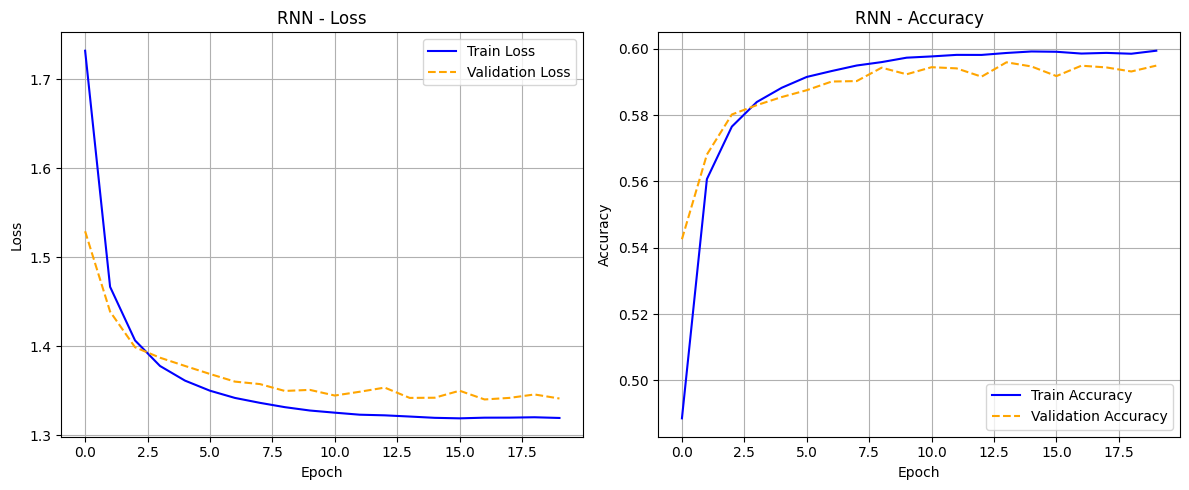

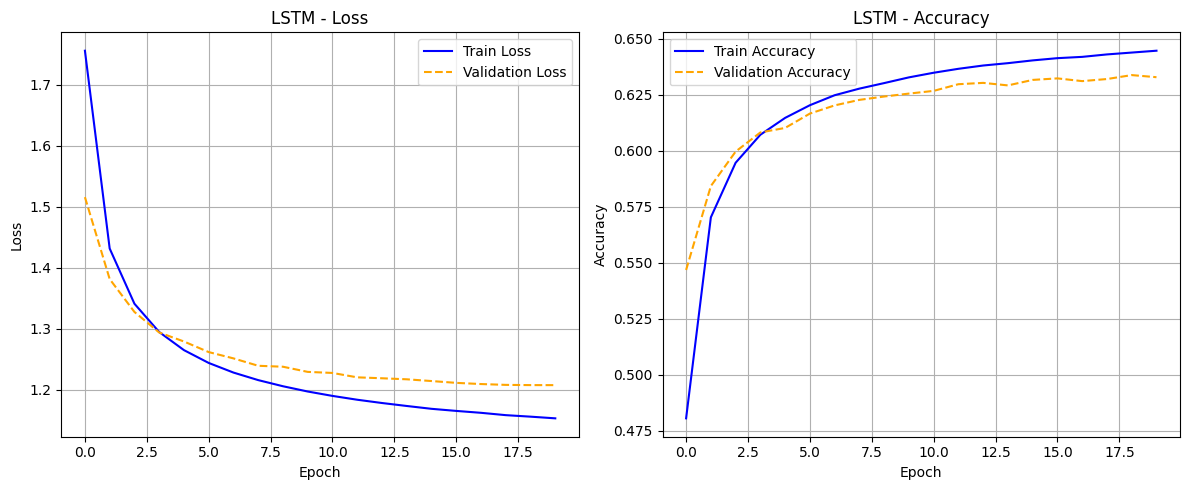

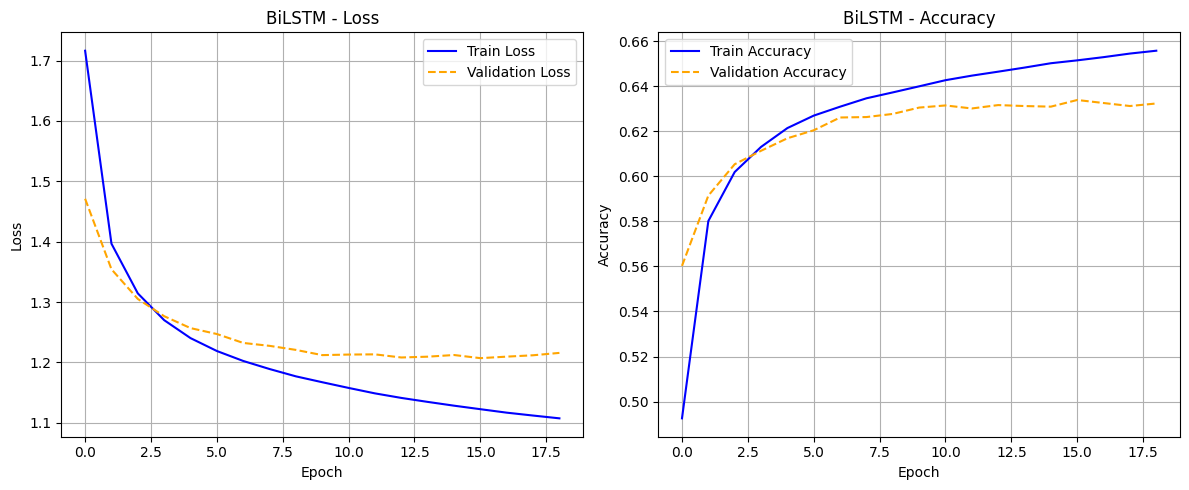

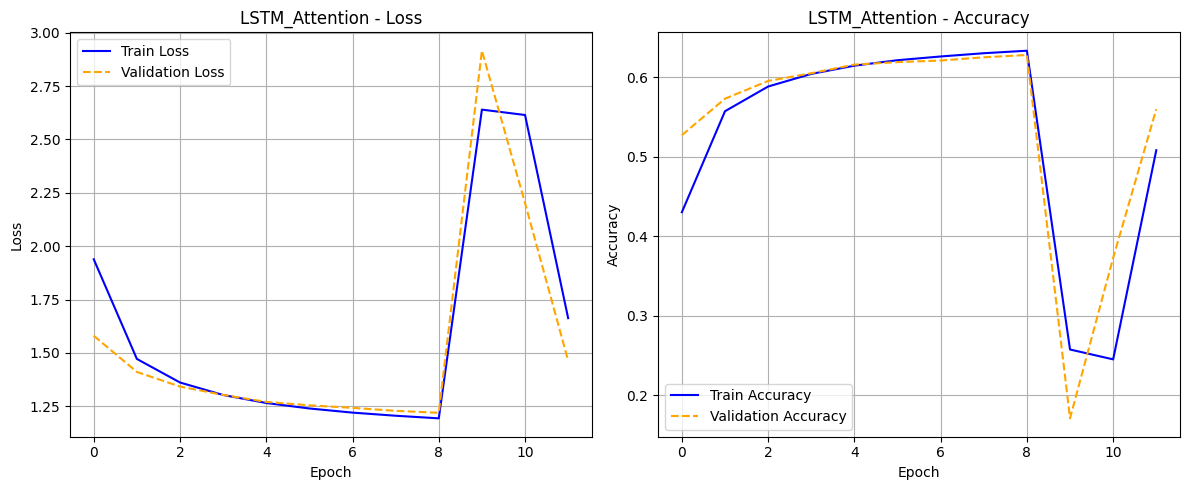

In [ ]:
def plot_model(model_name, history, save_path_prefix='model_plots'):

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Loss
    ax1.plot(history['loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
    ax1.set_title(f'{model_name} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(history['accuracy'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--')
    ax2.set_title(f'{model_name} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f'{save_path_prefix}_{model_name.lower()}.png')
    plt.show()

# Plot for each model
for model_name, result in results.items():
    plot_model(model_name, result['history'])



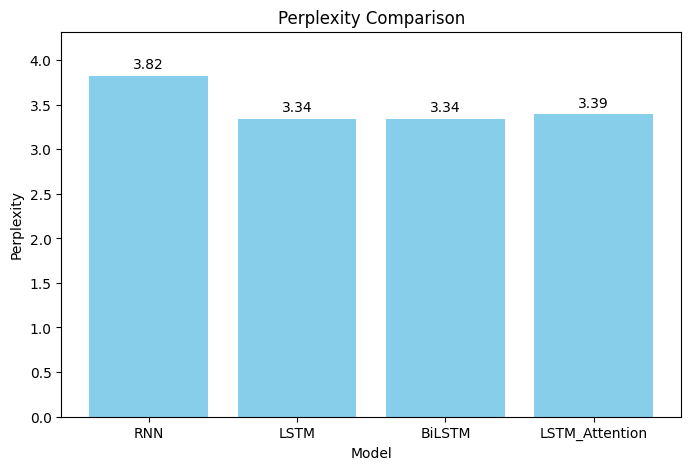

In [ ]:
import matplotlib.pyplot as plt

# Perplexity scores
model_names = ['RNN', 'LSTM', 'BiLSTM', 'LSTM_Attention']
perplexities = [3.82, 3.34, 3.34, 3.39]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, perplexities, color='skyblue')
plt.title('Perplexity Comparison')
plt.xlabel('Model')
plt.ylabel('Perplexity')
plt.ylim(0, max(perplexities) + 0.5)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{height:.2f}', ha='center', va='bottom')

plt.show()
